This Jupyter Notebook demonstrates how to enable the GridBallast controllers for a load (a water heater or a zip load) in GridLAB-D. 

We have four controllers which can be applied on each load, namely
- lock mode controller
- frequency controller
- voltage controller
- thermostat controller [optional for zip load]

Lock mode controller can force the load to be either ON/OFF during certain period. 

Frequency and voltage controller respond to frequency and voltage changes within a deadband to decide whether to bring up or shut down the load. Frequency controller requires an external frequency player to feed the frequency to the system. Voltage controller can access the voltage line directly in the system. Additionally, we also bring the "jitter function" to these two controllers where the control of ON/OFF is delayed for a random period of time. 

Thermostat controller is optional, which is only applicable to thermostat controlled loads (TCLs, e.g., water heater). For zip load, we can ignore this controller.

The detailed usage of these controllers will be explained below with some simple examples.

To run this notebook, please make sure you are in a UNIX based environment and have all the necessary python packages installed (plotly, matplotlib, numpy, pandas).

In [1]:
!ls

controller_usage_demonstration_new.ipynb
controller_usage_demonstration_new.pdf
correct_path.sh
frequency.PLAYER
hot_water_demand.glm
local_gd
lock_mode_schedule.glm
smSingle.glm
smSingle_4controller_freq_volt_lock_mode.glm
smSingle_4controller_freq_volt_lock_mode_abnormal.glm
smSingle_base.glm
smSingle_lenient_freq.glm
smSingle_lenient_freq_lock_mode.glm
smSingle_strict_freq.glm
smSingle_strict_freq_jitter60.glm
smSingle_strict_freq_jitter600.glm
smSingle_strict_volt.glm


The gridlab-d binary file is stored within **local_gd** directory along with libraries. We can check the version of the gridlabd using the following command:

In [2]:
!local_gd/bin/gridlabd --version

GridLAB-D 4.0.0-17345 (jingkungao@JKs-MBP.local:Documen) 64-bit MACOSX RELEASE


The above listed **local_gd/bin/gridlabd** is the binary version of the gridlab-d software with controlling functionality. In addition to that, we have **.glm** files and generated **.csv** files. We also have a **frequency.PLAYER** containing the 1-second resolution frequency information.

The version of the gridlab-d binary file and the content of the frequency.PLAYER can be seen below.

If the version of the gridlab-d does not work, we can disable the comments below and run the command to compile the source and install the gridlab-d to the machine.

In [3]:
# %%bash
# cd ~
# git clone -b feature/730 https://git@github.com:INFERLab/gridlab-d.git
# cd gridlab-d 
# cd third_party 
# chmod +x install_xercesc 
# . install_xercesc 
# tar -xvf cppunit-1.12.0.tar.gz
# cd cppunit-1.12.0
# ./configure LDFLAGS="-ldl"
# make 
# sudo make install
# cd ../..
# autoreconf -isf 
# ./configure 
# make 
# sudo make install

In [4]:
!head -5 frequency.PLAYER

2012-01-01 00:00:00 EST,59.9769
2012-01-01 00:00:01 EST,59.9763
2012-01-01 00:00:02 EST,59.9715
2012-01-01 00:00:03 EST,59.9714
2012-01-01 00:00:04 EST,59.972


We can further plot the frequency data to get a better sense of it.

In [5]:
# install necessary packages 
# uncomment the lines below if the system does not have them
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install plotly

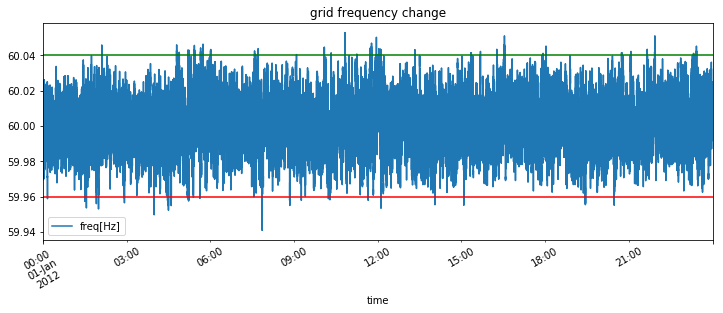

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode,\
                            plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

raw_freq = pd.read_csv('frequency.PLAYER',index_col=0,\
                       names=['time','freq[Hz]'],
                       parse_dates=True,\
                       infer_datetime_format=True)

freq_low = 59.96
freq_high = 60.04

ax = raw_freq.plot(figsize=(12,4),rot=30,
                  title='grid frequency change')
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')

Next, we will run **local_gd/bin/gridlabd** on different **.glm** files and plot the outputs showing the difference with and without controllers.

We start with running **smSingle_base.glm**, which is almost same as the original **smSingle.glm** provided by NRECA to us with the main difference being that we changed the simulation clock and added a recoreder for waterheater1 at the end.

# Base case (one thermostat controller)
We begin with the same circuit provided by NRECA (smSingle.glm), and modify it slightly as follows:

* We change the simulation time to match the time of **frequency.PLAYER** and add a recorder to record the waterheater measurements and the ZIP load measurements (in this case, a fan). Note that we record data for waterheater1 as an example but it could be used for any waterheater. 
* We also set the timestep to 1 second instead of 60 seconds. 
* For a more realistic water draw schedule, we include a **hot_water_demand.glm** which exhibits typical the weekday and weekend water demand usage patterns.

Below we illustrate some of those changes made to the glm file:

In [7]:
# from 2012-01-01 to 2012-01-02
!head -9 smSingle_base.glm

clock {
	timezone PST+8PDT;
	starttime '2012-01-01 00:00:00';
	stoptime '2012-01-02 00:00:00';
};

#include "hot_water_demand.glm";

#set minimum_timestep=1;


In [8]:
# record data for waterheater1 and fan2(zipload) at 1s resolution
!tail -14 smSingle_base.glm

object recorder {
	interval 1;
	property base_power;
	file fan2_base.csv;
	parent fan2;
};

object recorder {
	interval 1;
	property measured_frequency,temperature,actual_load,is_waterheater_on,water_demand;
		// current_tank_status,waterheater_model,heatgain,power_state;
	file wh1_base.csv;
	parent waterheater1;
};

We are now ready to run a simulation with the base case (no control).

In [9]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_base.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 35 objects
Parallelism                    1 thread
Total time                  20.0 seconds
  Core time                  2.2 seconds (11.1%)
    Compiler                 1.3 seconds (6.6%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.9%)
  Model time                17.8 seconds/thread (88.9%)
Simulation time                1 days
Simulation speed              42 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_base.csv** and **fan2_base.csv** from the simulation.

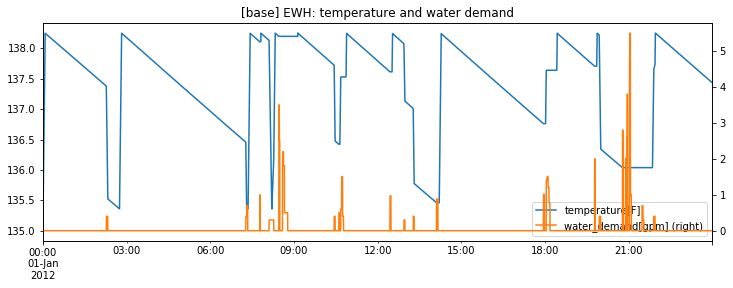

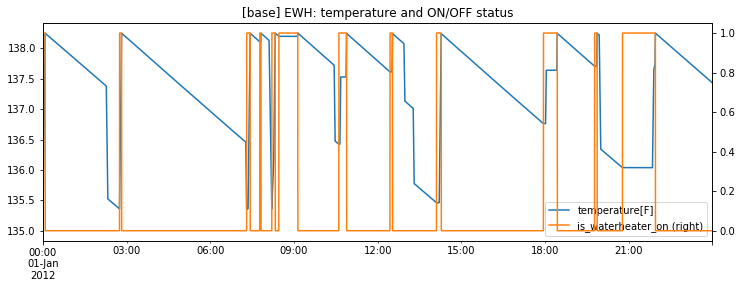

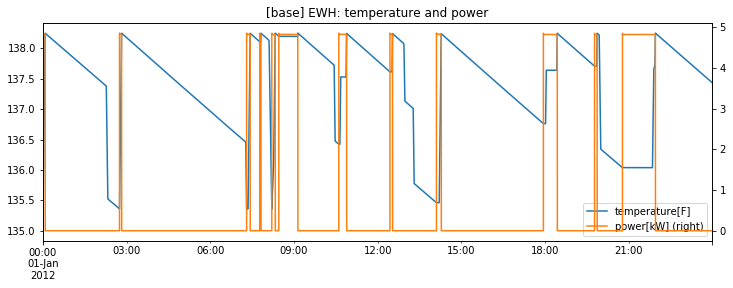

In [10]:
df_base = pd.read_csv('wh1_base.csv',sep=',',header=8,
            index_col=0,parse_dates=True,infer_datetime_format=True,
            names=['freq[Hz]','temperature[F]','power[kW]',\
                'is_waterheater_on','water_demand[gpm]'])

df_base[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[base] EWH: temperature and water demand')

df_base[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[base] EWH: temperature and ON/OFF status')

df_base[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[base] EWH: temperature and power')

In [11]:
# We can also plot the interactive version of the plot 
# during certain period
def plotly_plotdf(df,title='Interactive plot of column variables'):
    if len(df)>20000:
        print('Too many points, please reduce number of points!')
        return
    data = []
    for i in df.columns:
        trace = go.Scatter(
            name = i,
            x = df.index,
            y = df[i]
        )
        data.append(trace)
    fig = go.Figure(
        data = data,
        layout = go.Layout(showlegend=True,
                          title=title)
    )
    iplot(fig)

In [12]:
# we can toggle the varialbe to visualize each of them
# uncomment when you are running IPython notebook
# plotly_plotdf(df_base.resample('1min').mean())

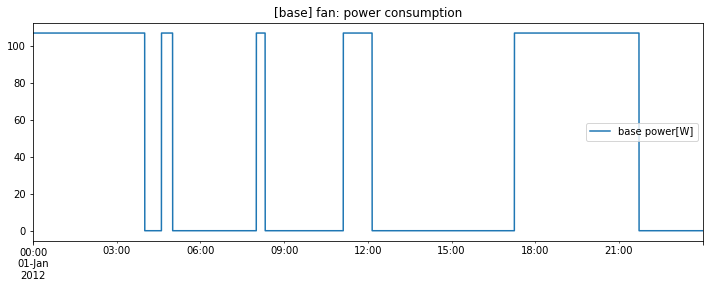

In [13]:
df_base_fan = pd.read_csv('fan2_base.csv',sep=',',header=8,
                 index_col=0,parse_dates=True,
                 infer_datetime_format=True,
                 names=['base power[W]'])
df_base_fan = df_base_fan*1000
df_base_fan.plot(figsize=(12,4),
                title='[base] fan: power consumption')

The above example has one thermostat controller for the water heater. For fan, there is no controller imposed, instead, a schedule is forced to the load. Moving next, we will consider adding more controllers to the base.

# Two controllers
We first look at the case where we add one more controller to the water heater. This additional controller could be the frequency controller, voltage controller, or the lock mode controller. We start with a frequency controller with lenient frequency control.

Noticed by adding an additional controller, we assume the thermostat controller has a higher priority compared with others. In other words, we only consider letting other controllers to take control if there is no thermal violation. This priority list could be changed though, which we will talk later.

## Lenient Frequency Control 
To configure the GridBallast controller, we set specific properties of the waterheater object in the glm file. The properties corresponding to the frequency controller include:

*	enable_freq_control       [boolean]
*	freq_lowlimit             [float]
*	freq_uplimit              [float]

For this test we modify waterheater 1 and fan 2 to enable the frequency control and set a wide frequency dead-band (59.9Hz - 60.1Hz). We expect the GridBallast controller to be rarely triggered. 


In [14]:
!head -611 smSingle_lenient_freq.glm|tail -21

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
    };
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	heat_mode ELECTRIC;
};


In [15]:
!head -756 smSingle_lenient_freq.glm|tail -19

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	groupid fan;
};


In [16]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_lenient_freq.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  29.0 seconds
  Core time                  3.8 seconds (13.2%)
    Compiler                 1.1 seconds (4.0%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.1 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.7%)
  Model time                25.2 seconds/thread (86.8%)
Simulation time                1 days
Simulation speed              31 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_lenient_freq.csv** and **fan2_lenient_freq.csv** from the simulation.

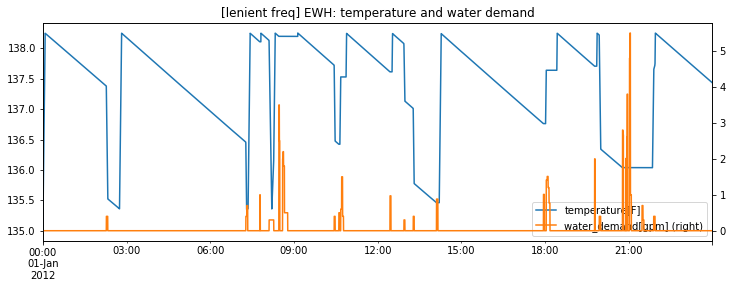

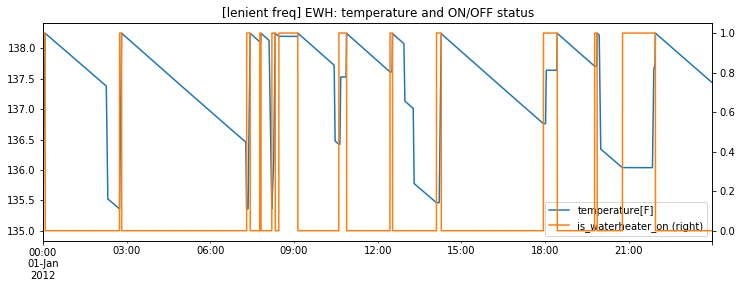

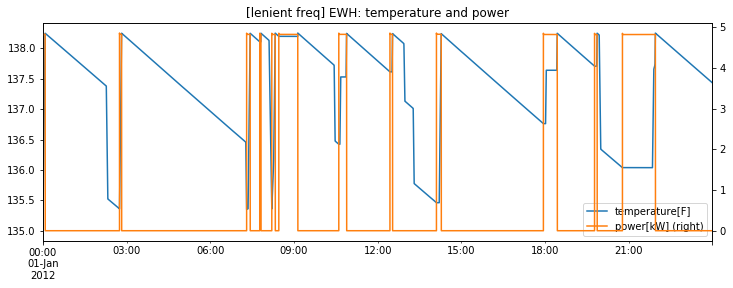

In [17]:
# We save data to wh1_lenient_freq.csv and plot the results
df_lenient_freq = pd.read_csv('wh1_lenient_freq.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_lenient_freq[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[lenient freq] EWH: temperature and water demand')

df_lenient_freq[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[lenient freq] EWH: temperature and ON/OFF status')

df_lenient_freq[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[lenient freq] EWH: temperature and power')    

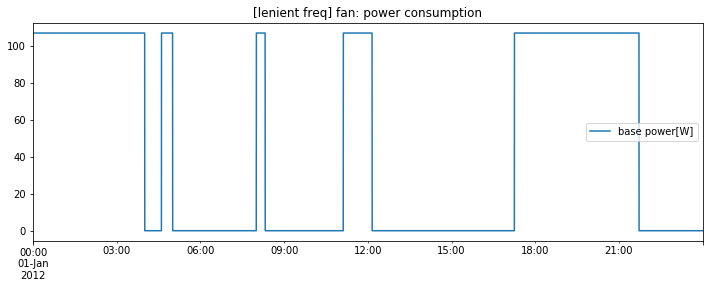

In [18]:
df_lenient_fan = pd.read_csv('fan2_lenient_freq.csv',
                    sep=',',header=8,
                    index_col=0,parse_dates=True,
                    infer_datetime_format=True,
                    names=['base power[W]'])
df_lenient_fan = df_lenient_fan*1000
df_lenient_fan.plot(figsize=(12,4),
        title='[lenient freq] fan: power consumption')

## Strict Frequency Control 
We modify waterheater 1 and fan 2 to enable the frequency control, but we impose a tighter frequency deadband (59.97Hz - 60.03Hz). In other words, the gridballast controller should be triggered very often. 

In [19]:
!head -611 smSingle_strict_freq.glm|tail -21

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	heat_mode ELECTRIC;
};


In [20]:
!head -756 smSingle_strict_freq.glm|tail -19

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	groupid fan;
};


In [21]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  20.0 seconds
  Core time                  2.6 seconds (12.8%)
    Compiler                 1.2 seconds (5.9%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.1%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.1 seconds (0.7%)
  Model time                17.4 seconds/thread (87.2%)
Simulation time                1 days
Simulation speed              44 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_strict_freq.csv** and **fan2_strict_freq.csv** from the simulation.

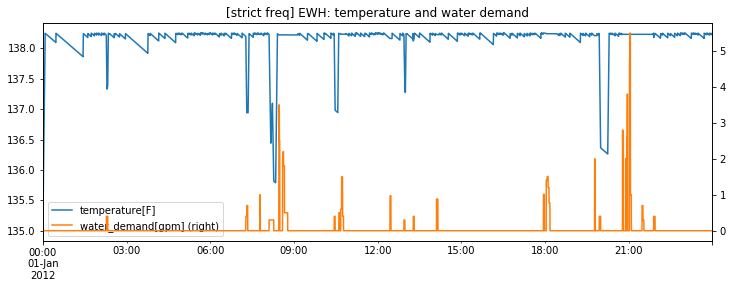

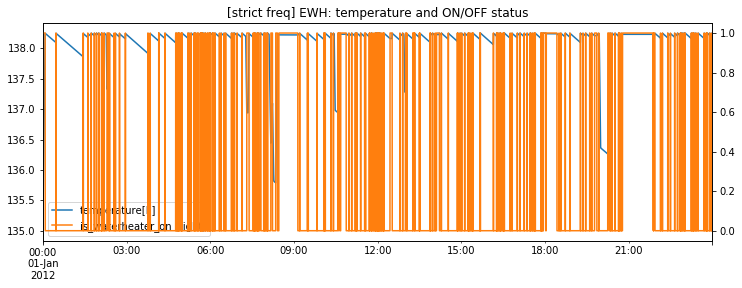

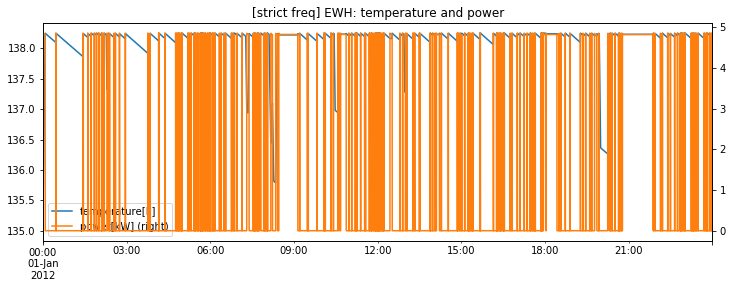

In [22]:
# We save data to wh1_strict_freq.csv and plot the results
df_strict_freq = pd.read_csv('wh1_strict_freq.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_strict_freq[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict freq] EWH: temperature and water demand')

df_strict_freq[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict freq] EWH: temperature and ON/OFF status')

df_strict_freq[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict freq] EWH: temperature and power') 

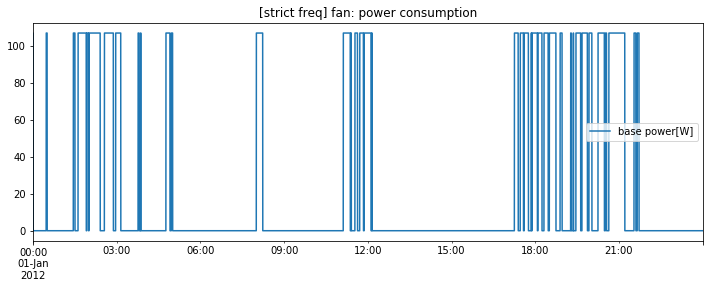

In [23]:
df_strict_fan = pd.read_csv('fan2_strict_freq.csv',
                 sep=',',header=8,
                 index_col=0,parse_dates=True,
                 infer_datetime_format=True,
                 names=['base power[W]'])
df_strict_fan = df_strict_fan*1000
df_strict_fan.plot(figsize=(12,4),
        title='[strict freq] fan: power consumption')

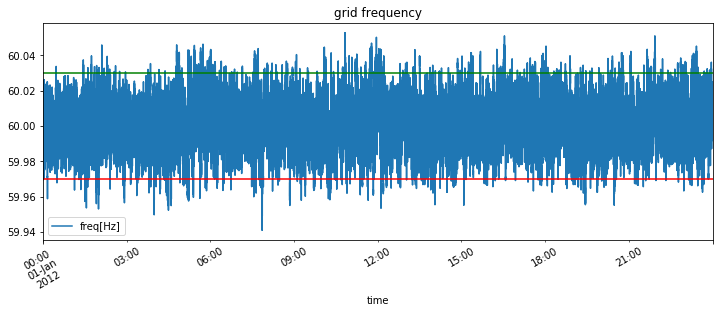

In [24]:
# we can plot the frequency and the lower/upper limit again
freq_low = 59.97
freq_high = 60.03

ax = raw_freq.plot(figsize=(12,4),rot=30,
                  title='grid frequency')
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')

## Strict Voltage Control 
We modify waterheater 1 and fan 2 to enable the voltage controller, with a band of [240.7,241.3] for the waterheater and [120.4,120.7] for the zipload. Notice in the case of voltage controller, we don't need to supply an external voltage.PLAYER file, instead, we can access the voltage line directly in the system.

In [25]:
!head -608 smSingle_strict_volt.glm|tail -19


object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	enable_volt_control true;
	volt_lowlimit 240.7;
	volt_uplimit 241.3;
	heat_mode ELECTRIC;
};



In [26]:
!head -748 smSingle_strict_volt.glm|tail -15

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	enable_volt_control true;
	volt_lowlimit 120.4;
	volt_uplimit 120.7;
	groupid fan;
};


In [27]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_volt.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 35 objects
Parallelism                    1 thread
Total time                  22.0 seconds
  Core time                  3.0 seconds (13.6%)
    Compiler                 1.2 seconds (5.3%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.8%)
  Model time                19.0 seconds/thread (86.4%)
Simulation time                1 days
Simulation speed              38 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_strict_volt.csv** and **fan2_strict_volt.csv** from the simulation.

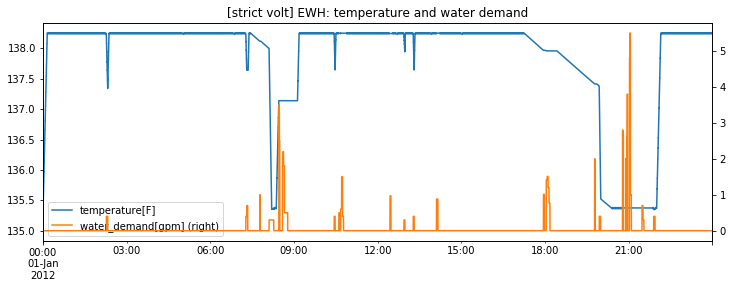

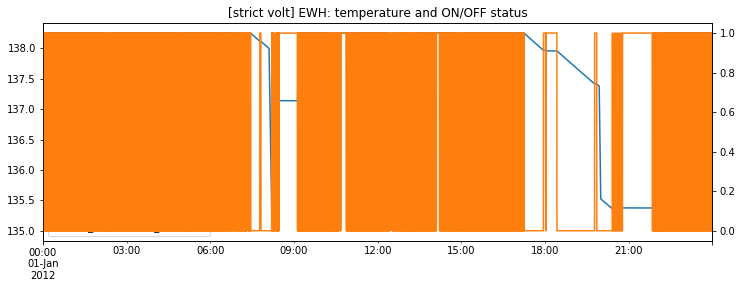

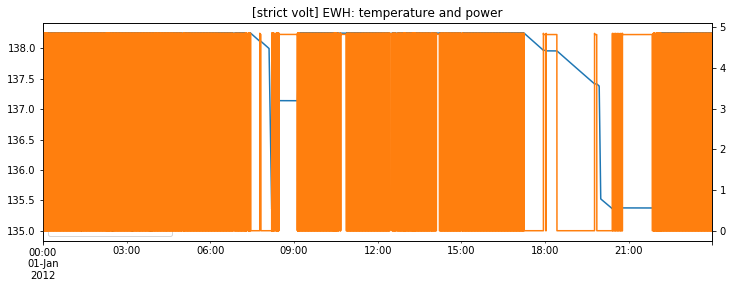

In [28]:
# We save data to wh1_strict_freq.csv and plot the results
df_strict_volt = pd.read_csv('wh1_strict_volt.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['volt[V]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_strict_volt[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict volt] EWH: temperature and water demand')

df_strict_volt[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict volt] EWH: temperature and ON/OFF status')

df_strict_volt[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict volt] EWH: temperature and power') 

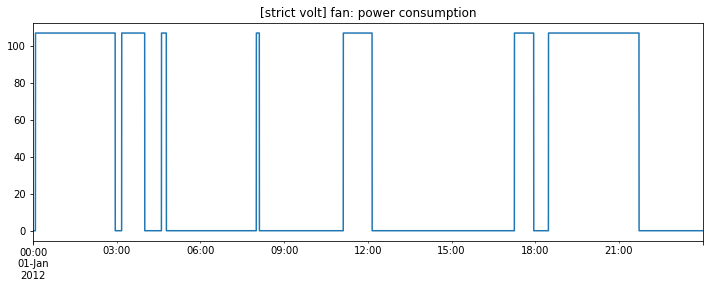

In [29]:
df_strict_fan_volt = pd.read_csv('fan2_strict_volt.csv',
                 sep=',',header=8,
                 index_col=0,parse_dates=True,
                 infer_datetime_format=True,
                 names=['voltage[V]','base power[W]'])
df_strict_fan_volt['base power[W]'] = df_strict_fan_volt['base power[W]']*1000
df_strict_fan_volt['base power[W]'].plot(figsize=(12,4),
        title='[strict volt] fan: power consumption')

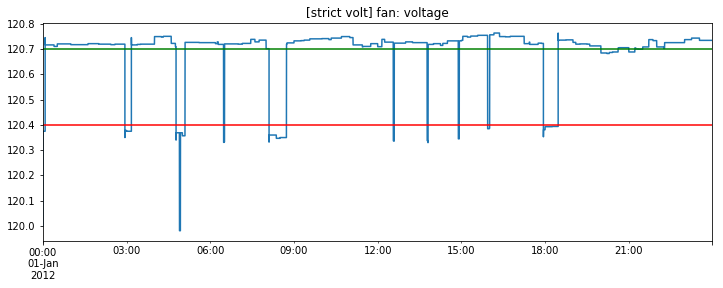

In [30]:
# we can plot the voltage and the lower/upper limit for the fan

volt_low = 120.4
volt_high = 120.7

ax = df_strict_fan_volt['voltage[V]'].plot(figsize=(12,4),
        title='[strict volt] fan: voltage')

ax.axhline(y=volt_low, c='red')
ax.axhline(y=volt_high, c='green')

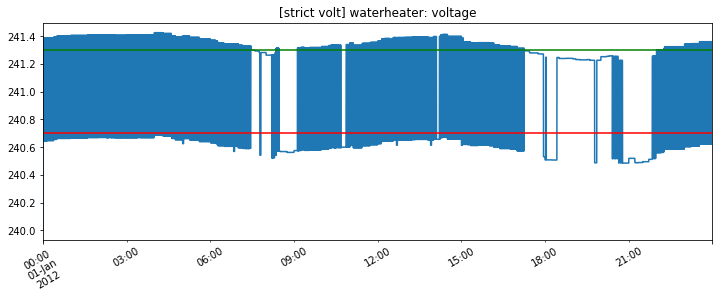

In [31]:
# we can plot the voltage and the lower/upper limit for the waterheater as well
volt_low = 240.7
volt_high = 241.3

ax = df_strict_volt['volt[V]'].plot(figsize=(12,4),rot=30,
                  title='[strict volt] waterheater: voltage')
ax.axhline(y=volt_low, c='red')
ax.axhline(y=volt_high, c='green')

## Strict Frequency Control with Jitter (1 min)
We now modify the previous case (with a tight frequency deadband) and add a jitter to the response of the waterheater and fan, such that the start of GridBallast event will delay randomly with an expected value of 60 seconds (1 min). This can be done by specifying a property called **average_delay_time**. Internally, the controller delay follows a uniform distribution over the interval [1,2*average_delay_time]. 

We use 60 seconds to clearly illustrate the difference in the power consumption patterns of the water heater previously illustrated and this one with jitter control enabled. Needless to say, users can set these values differently depending on how many water heaters are connected to the network or other considerations.

In [32]:
!head -612 smSingle_strict_freq_jitter60.glm|tail -22

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	heat_mode ELECTRIC;
	average_delay_time 60;
};


In [33]:
!head -758 smSingle_strict_freq_jitter60.glm|tail -20

object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	average_delay_time 60;
	groupid fan;
};


In [34]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq_jitter60.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  28.0 seconds
  Core time                  3.4 seconds (12.3%)
    Compiler                 1.2 seconds (4.3%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.8%)
  Model time                24.6 seconds/thread (87.7%)
Simulation time                1 days
Simulation speed              32 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

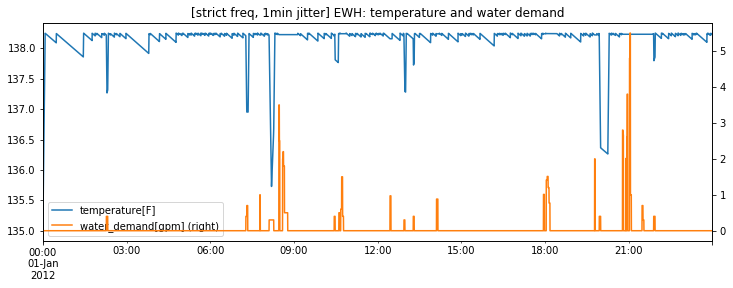

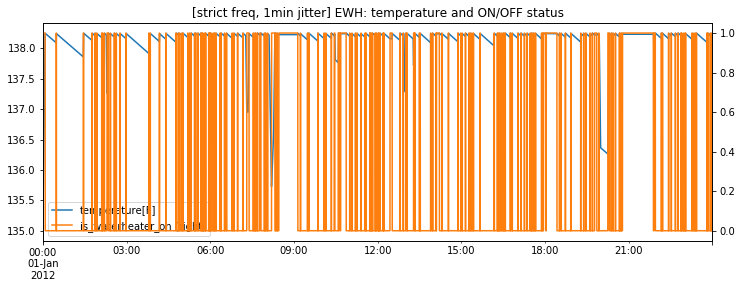

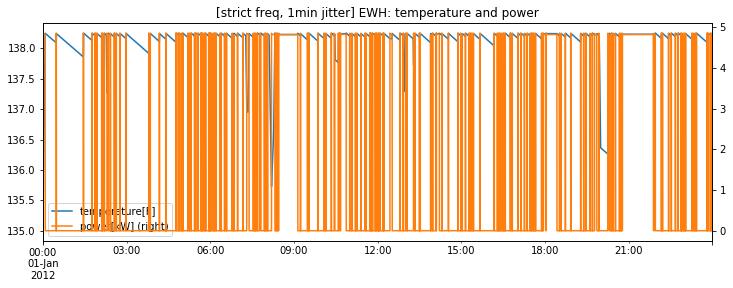

In [35]:
# We save data to wh1_strict_freq_jitter60.csv and plot the results
df_wh_jitter60 = pd.read_csv('wh1_strict_freq_jitter60.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_wh_jitter60[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict freq, 1min jitter] EWH: temperature and water demand')

df_wh_jitter60[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict freq, 1min jitter] EWH: temperature and ON/OFF status')

df_wh_jitter60[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict freq, 1min jitter] EWH: temperature and power') 

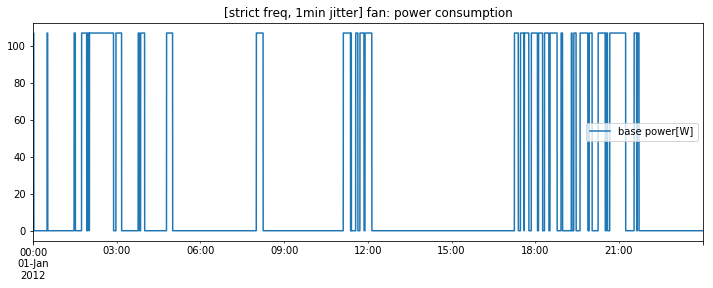

In [36]:
df_fan_jitter60 = pd.read_csv('fan2_strict_freq_jitter60.csv',
                        sep=',',
                        header=8,index_col=0,parse_dates=True,
                        infer_datetime_format=True,
                        names=['base power[W]'])
df_fan_jitter60 = df_fan_jitter60*1000
df_fan_jitter60.plot(figsize=(12,4),
        title='[strict freq, 1min jitter] fan: power consumption')

As we can see, after applying the jitter, the water heater should be engaged less often. However, since the jitter time is too short, we can barely see the difference unless we zoom in.

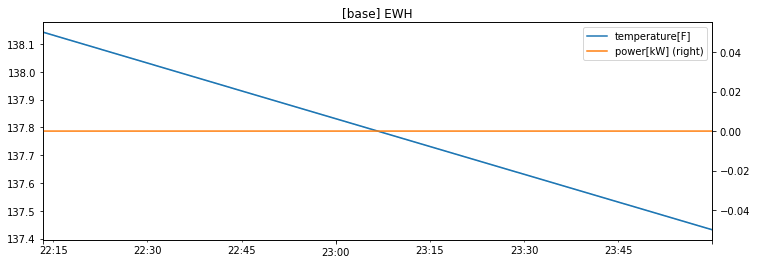

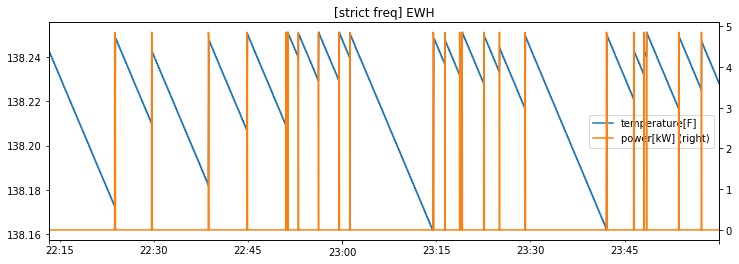

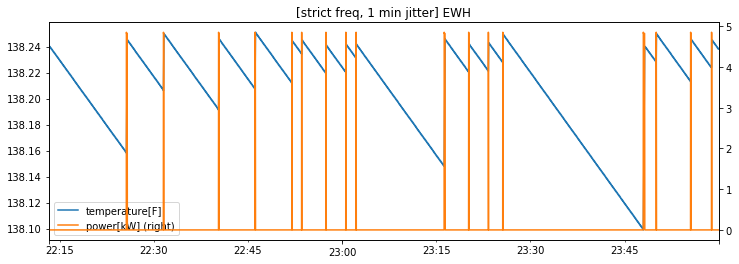

In [37]:
# we look at jitter for water heater in shorter duration
# As we can see, they behave slightly different
df_base.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[base] EWH')
df_strict_freq.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[strict freq] EWH')
df_wh_jitter60.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                title='[strict freq, 1 min jitter] EWH')

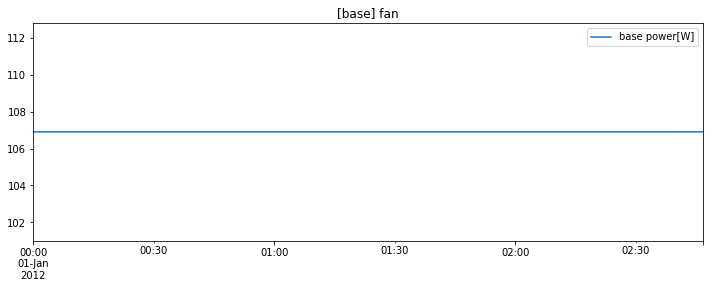

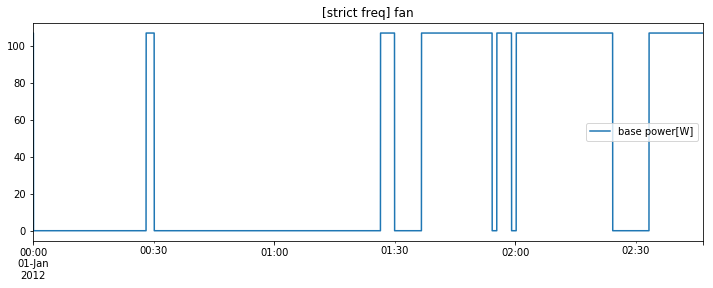

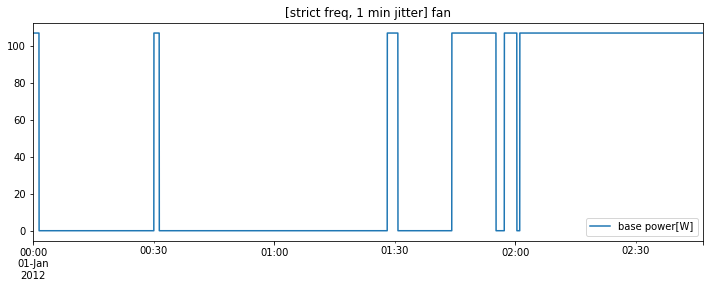

In [38]:
# we look at jitter for the zipload in shorter duration as well
# As we can see, they behave quiet differently since we don't need to consider
# the thermal condition here. Once the frequency violation is detected, we can
# either turn on/turn off the load regardless of the origin schedule
df_base_fan.iloc[:10000].plot(figsize=(12,4),
                             title='[base] fan')
df_strict_fan.iloc[:10000].plot(figsize=(12,4),
                    title='[strict freq] fan')
df_fan_jitter60.iloc[:10000].plot(figsize=(12,4),
        title='[strict freq, 1 min jitter] fan')

 As is seen, after applying the jitter, it tends to correct the power trace from strict frequency control case to the base case. It is obvious for the zipload[fan] case. Let's try the jitter with longer duration to see the same trend for the waterheater.

## Strict Frequency Control with Jitter (10 mins)
We now modify the jitter such that the start of GridBallast event will delay randomly with an expected value of 600 seconds (10 mins) so that we can clearly see the jitter effects in the electric water heater as well.

In [39]:
!head -613 smSingle_strict_freq_jitter600.glm|tail -23

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	heat_mode ELECTRIC;
	average_delay_time 600;
};



In [40]:
!head -758 smSingle_strict_freq_jitter600.glm|tail -21


object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.97;
	freq_uplimit 60.03;
	average_delay_time 600;
	groupid fan;
};


In [41]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_strict_freq_jitter600.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  24.0 seconds
  Core time                  3.0 seconds (12.6%)
    Compiler                 1.3 seconds (5.4%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.1%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (0.8%)
  Model time                21.0 seconds/thread (87.4%)
Simulation time                1 days
Simulation speed              37 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

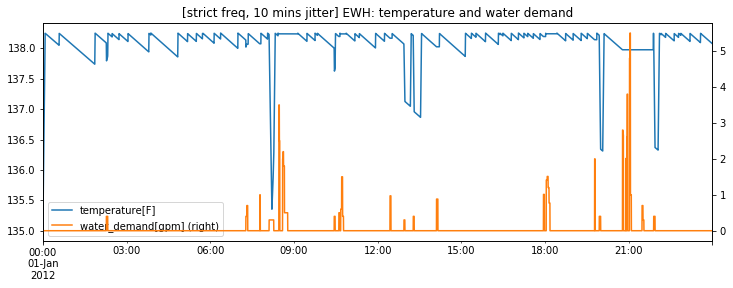

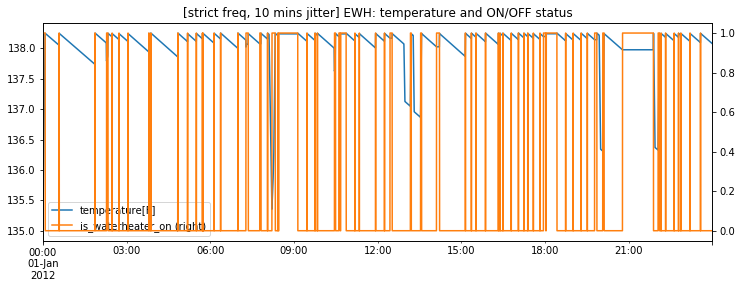

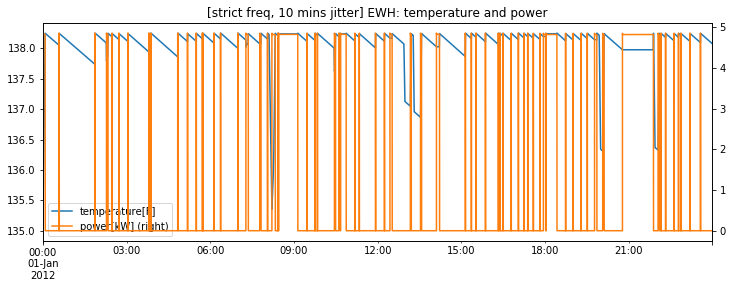

In [42]:
# We save data to wh1_strict_freq_jitter600.csv and plot the results
df_wh_jitter600 = pd.read_csv('wh1_strict_freq_jitter600.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_wh_jitter600[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[strict freq, 10 mins jitter] EWH: temperature and water demand')

df_wh_jitter600[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[strict freq, 10 mins jitter] EWH: temperature and ON/OFF status')

df_wh_jitter600[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[strict freq, 10 mins jitter] EWH: temperature and power') 

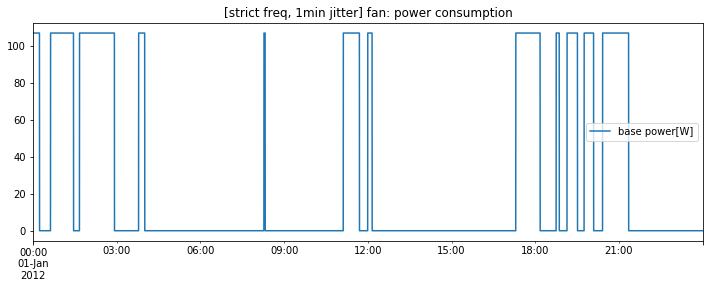

In [43]:
df_fan_jitter600 = pd.read_csv('fan2_strict_freq_jitter600.csv',
                        sep=',',
                        header=8,index_col=0,parse_dates=True,
                        infer_datetime_format=True,
                        names=['base power[W]'])
df_fan_jitter600 = df_fan_jitter600*1000
df_fan_jitter600.plot(figsize=(12,4),
        title='[strict freq, 1min jitter] fan: power consumption')

As we can see, after applying the 10 min jitter, now the water heater is engaged less often than in the previous experiment without jitter.

As we did in previous examples, we now look into a shorter duration to better understand the effect of the jitter.

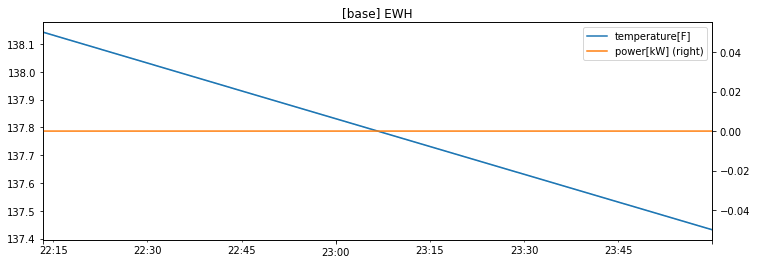

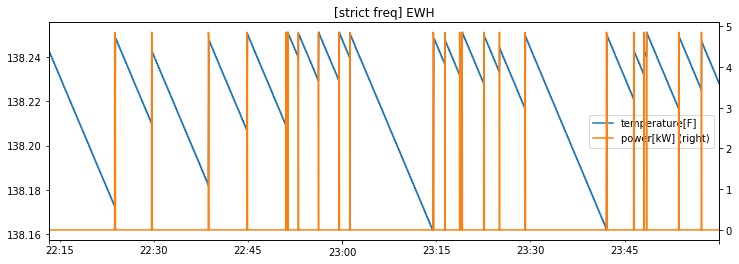

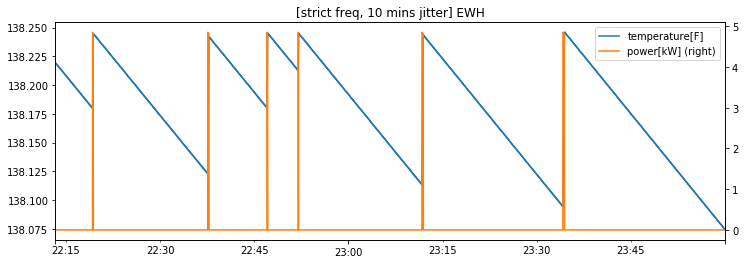

In [44]:
# we look at jitter for the electric water heater in shorter duration
# As we can see, they behave slightly different, the one with jitter behaves
# more like the one without frequency control (base case)
df_base.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[base] EWH')
df_strict_freq.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
                          title='[strict freq] EWH')
df_wh_jitter600.iloc[80000:100000][['temperature[F]',
        'power[kW]']].plot(figsize=(12,4),
                           secondary_y='power[kW]',
            title='[strict freq, 10 mins jitter] EWH')

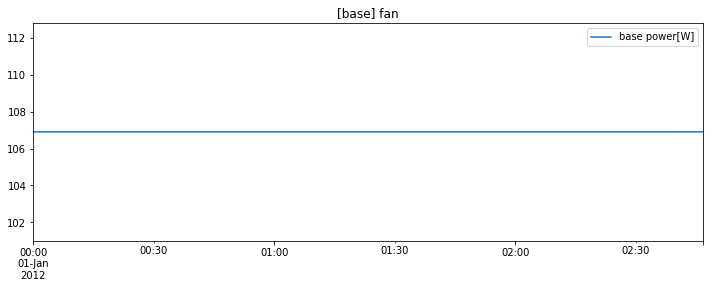

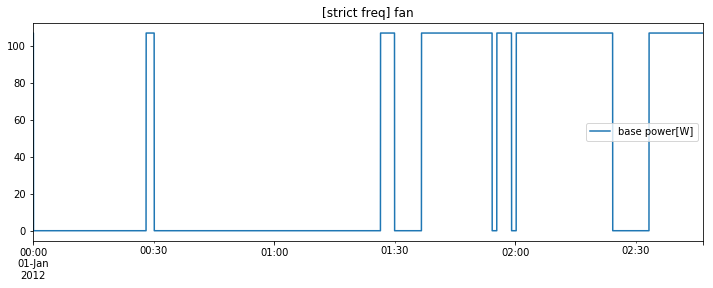

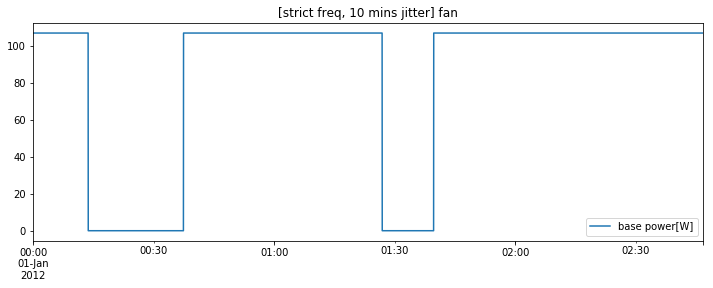

In [45]:
# we look at jitter for the zipload in shorter duration as well
# As we can see, when we apply jitter, it behaves more like 
# the one without frequency control, and the longer the jitter duration, 
# the more likely the power trace becomes to the one with out frequency control
df_base_fan.iloc[:10000].plot(figsize=(12,4),
                             title='[base] fan')
df_strict_fan.iloc[:10000].plot(figsize=(12,4),
                    title='[strict freq] fan')
df_fan_jitter600.iloc[:10000].plot(figsize=(12,4),
        title='[strict freq, 10 mins jitter] fan')

We can apply the same jitter to the voltage controller as well. We will skip those examples. In addition to that, we can also add a lock mode controller, which we will demonstrate in the three controllers case.

# Three Controllers
In addition to the thermostat controllers, we can add two more controllers to the waterheater, here we show how we can add frequency controller and lock mode controller.
## Lenient Frequency Control & Lock Mode Enabled

Noticed by adding two more controllers, we assume the following priority list by default:
- waterheater: thermostat controller > lock mode controller > frequency controller 
- zipload: lock mode controller > frequency controller

This list could be changed later by feeding an additional parameter, which we will explain in the four controllers case.

We will use a very simple example to demonstrate how to enable the lock for ON/OFF during certain period. For example, if we want to enable lock between 18:00-22:00, and force load ON between 19:00-21:00, and force load OFF between from 18:00-19:00 and 21:00-22:00, we can specify a schedule file like this.

In [46]:
cat lock_mode_schedule.glm

schedule temp_lock_enable {
	* 0-17 * * * 0;
	* 18-21 * * * 1;
	* 22-23 * * * 0;
};

schedule temp_lock_status {
	* 18 * * * 0;
	* 19-20 * * * 1;
	* 21 * * * 0;
};


In [47]:
# we decide not to override the thermostat setpoint by letting lock_OVERRIDE_TS to be false
# we can let this variable to be true if we want a very strict control of the TCLs
!head -614 smSingle_lenient_freq_lock_mode.glm|tail -24


object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
    };
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	heat_mode ELECTRIC;
	enable_lock temp_lock_enable;
	lock_STATUS temp_lock_status;
};


In [48]:
!head -761 smSingle_lenient_freq_lock_mode.glm|tail -22


object ZIPload {
	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.9;
	freq_uplimit 60.1;
	enable_lock temp_lock_enable;
	lock_STATUS temp_lock_status;
	groupid fan;
};


In [49]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_lenient_freq_lock_mode.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  29.0 seconds
  Core time                  3.3 seconds (11.4%)
    Compiler                 1.4 seconds (4.7%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.1%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.3 seconds (1.1%)
  Model time                25.7 seconds/thread (88.6%)
Simulation time                1 days
Simulation speed              31 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

Now, we plot the generated waterheater data stored in **wh1_lenient_freq_lock_mode.csv** and **fan2_lenient_freq_lock_mode.csv** from the simulation.

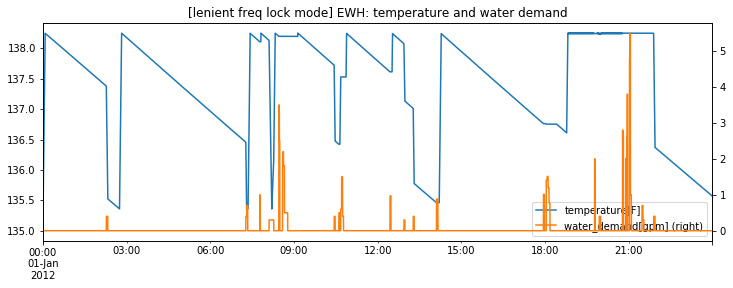

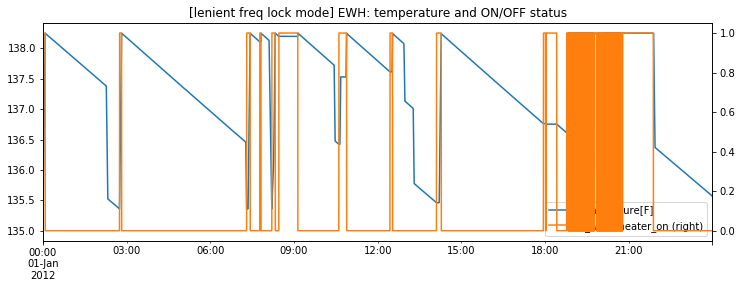

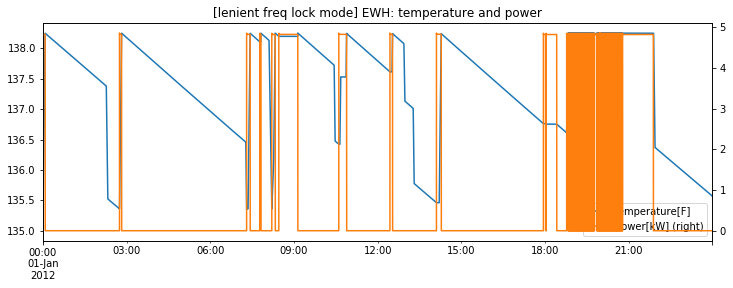

In [50]:
# We save data to wh1_lenient_freq.csv and plot the results
df_lenient_freq_lk = pd.read_csv('wh1_lenient_freq_lock_mode.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_lenient_freq_lk[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[lenient freq lock mode] EWH: temperature and water demand')

df_lenient_freq_lk[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[lenient freq lock mode] EWH: temperature and ON/OFF status')

df_lenient_freq_lk[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[lenient freq lock mode] EWH: temperature and power')    

As we can see, the load is off starting from 18:00, however, due to the water usage events, the temperature set point has a higher priority, and the load is ON to maintain the temperature within the dead band. 

Starting from 19:00, the load is forced ON, however, once the temperature reaches the upper band, the load is forced OFF, that is why we see the dense fluctuations between 19:00-21:00. 

Starting from 21:00, the load is supposed to be OFF, however, due to the temperature setting point has a higher priority, the load is forced to be ON to maintain the proper temperature. 

Now let's look at the fan.

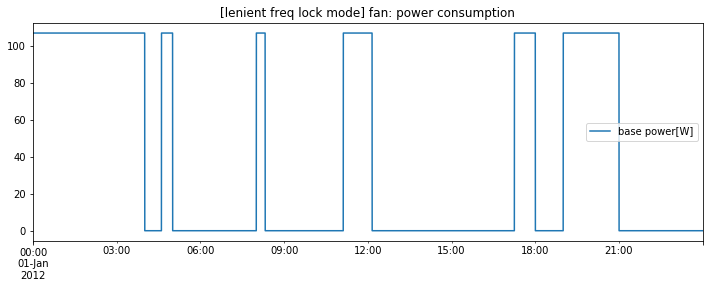

In [51]:
df_lenient_fan_lk = pd.read_csv('fan2_lenient_freq_lock_mode.csv',
                    sep=',',header=8,
                    index_col=0,parse_dates=True,
                    infer_datetime_format=True,
                    names=['base power[W]'])
df_lenient_fan_lk = df_lenient_fan_lk*1000
df_lenient_fan_lk.plot(figsize=(12,4),
        title='[lenient freq lock mode] fan: power consumption')

The fan is quite properly behaved, it is OFF between 18:00-19:00, ON between 19:00-21:00, OFF again between 21:00-22:00. Exactly as the lock mode schedule specified. We can also look at the origin power trace for comparison.

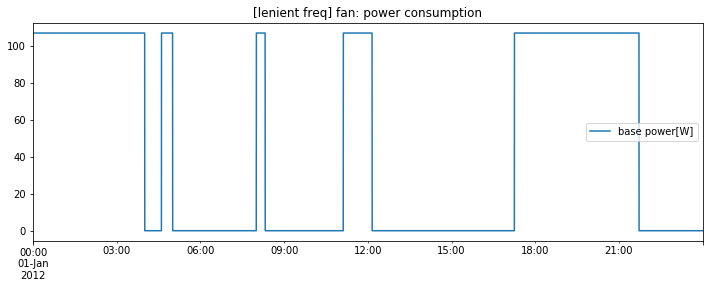

In [52]:
df_lenient_fan.plot(figsize=(12,4),
        title='[lenient freq] fan: power consumption')

# Four Controllers
Now we consider the ultimate case where we have all controllers for the load. The jitters are also enabled for both frequency/voltage controllers by setting up **average_delay_time**. And we can also decide what kind of priority we want to apply to the load by specifying the variable **controller_priority**.

## Normal controllers

In [53]:
!head -619 smSingle_4controller_freq_volt_lock_mode.glm|tail -28

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
    };
	enable_freq_control true;
	freq_lowlimit 59.96;
	freq_uplimit 60.04;
	heat_mode ELECTRIC;
	enable_volt_control true;
	volt_lowlimit 240.4;
	volt_uplimit 241.4;
	average_delay_time 120;
	enable_lock temp_lock_enable;
	lock_STATUS temp_lock_status;
	controller_priority 3214;
};


All the other properties have been explained before. For the property **controller_priority**, let's consider these four controllers:
- lock mode controller  [a]
- frequency controller  [b]
- voltage controller    [c]
- thermostat controller [d]

The number **3214** above means that the controllers are in the priority order of *d > a > b > c*.

The number **4321** below means that the controllers are in the priority order of *a > b > c > d*.

In [54]:
!head -771 smSingle_4controller_freq_volt_lock_mode.glm|tail -25

	name fan2;
	parent house2;
	power_fraction 0.013500;
	current_fraction 0.253400;
	base_power fan1*0.106899;
	impedance_pf 0.970000;
	current_pf 0.950000;
	power_pf -1.000000;
	impedance_fraction 0.733200;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
	};
	enable_freq_control true;
	freq_lowlimit 59.96;
	freq_uplimit 60.04;
	enable_volt_control true;
	volt_lowlimit 120.39;
	volt_uplimit 120.73;
	average_delay_time 120;
	enable_lock temp_lock_enable;
	lock_STATUS temp_lock_status;
	controller_priority 4321;
	groupid fan;
};


In [55]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_4controller_freq_volt_lock_mode.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  25.0 seconds
  Core time                  2.8 seconds (11.0%)
    Compiler                 1.4 seconds (5.6%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.1%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.3 seconds (1.0%)
  Model time                22.2 seconds/thread (89.0%)
Simulation time                1 days
Simulation speed              36 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock conten

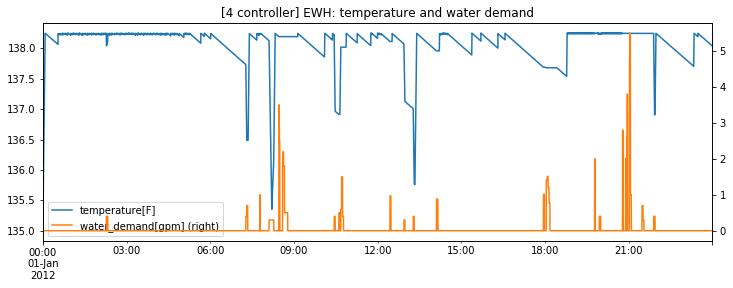

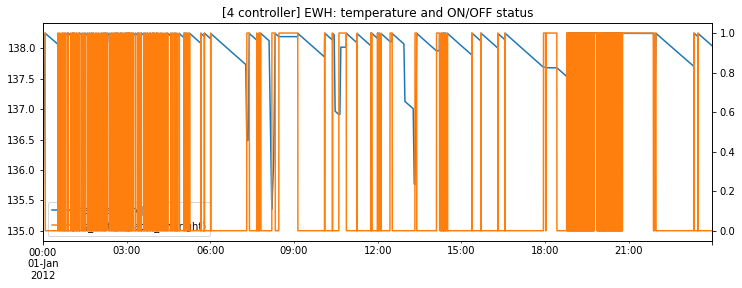

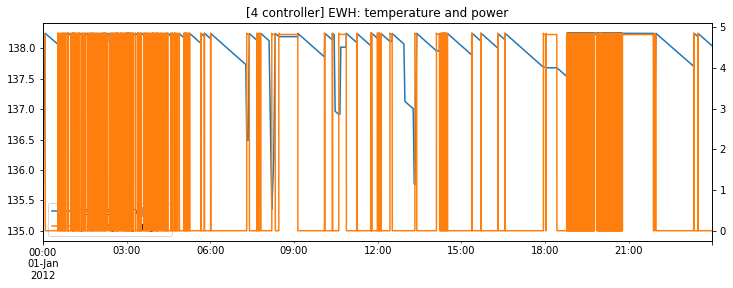

In [56]:
# We save data to wh1_lenient_freq.csv and plot the results
df_wh_4con_1 = pd.read_csv('wh1_4controller_1.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['volt[V]', 'freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_wh_4con_1[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[4 controller] EWH: temperature and water demand')

df_wh_4con_1[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[4 controller] EWH: temperature and ON/OFF status')

df_wh_4con_1[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[4 controller] EWH: temperature and power')    

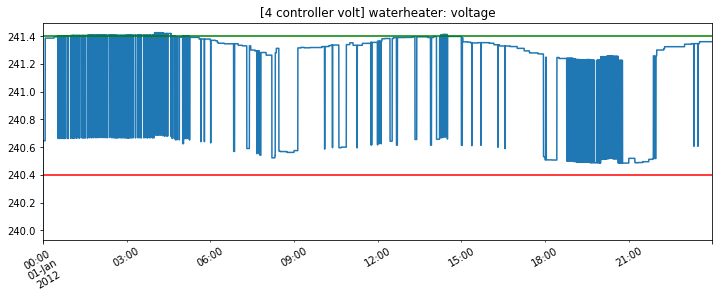

In [57]:
# we can plot the voltage and the lower/upper limit for the waterheater as well
volt_low = 240.4
volt_high = 241.4

ax = df_wh_4con_1['volt[V]'].plot(figsize=(12,4),rot=30,
                  title='[4 controller volt] waterheater: voltage')
ax.axhline(y=volt_low, c='red')
ax.axhline(y=volt_high, c='green')

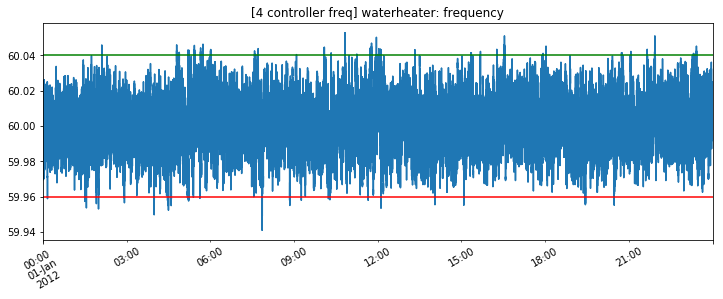

In [58]:
# we can plot the frequency and the lower/upper limit again
freq_low = 59.96
freq_high = 60.04

ax = df_wh_4con_1['freq[Hz]'].plot(figsize=(12,4),rot=30,
                  title='[4 controller freq] waterheater: frequency')
ax.axhline(y=freq_low, c='red')
ax.axhline(y=freq_high, c='green')

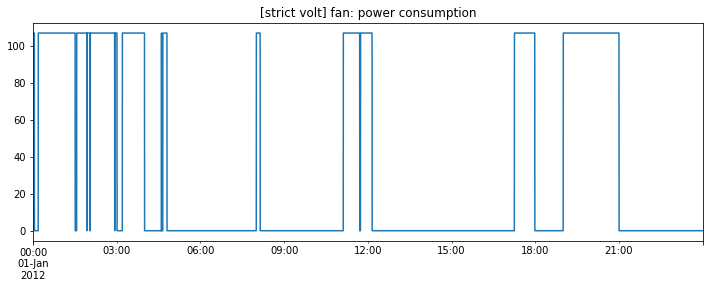

In [59]:
df_fan_4con_1 = pd.read_csv('fan2_4controller_1.csv',
                 sep=',',header=8,
                 index_col=0,parse_dates=True,
                 infer_datetime_format=True,
                 names=['voltage[V]','base power[W]'])
df_fan_4con_1['base power[W]'] = df_fan_4con_1['base power[W]']*1000
df_fan_4con_1['base power[W]'].plot(figsize=(12,4),
        title='[strict volt] fan: power consumption')

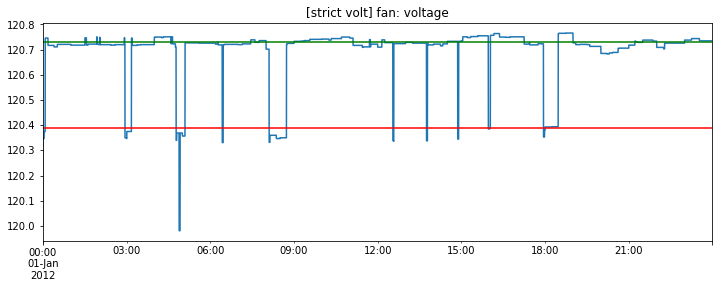

In [60]:
# we can plot the voltage and the lower/upper limit for the fan

volt_low = 120.39
volt_high = 120.73

ax = df_fan_4con_1['voltage[V]'].plot(figsize=(12,4),
        title='[strict volt] fan: voltage')

ax.axhline(y=volt_low, c='red')
ax.axhline(y=volt_high, c='green')

## Abnormal controllers
To show how the priority list matters for the controller, we consider the following abnormal examples where we change **controller_priority** to 4321, which means

lock controller > freq controller > volt controller > thermostat controller



In [61]:
!head -619 smSingle_4controller_freq_volt_lock_mode_abnormal.glm|tail -28

object waterheater {
	schedule_skew -810;
	water_demand weekday_hotwater*1;
	name waterheater1;
	parent house1;
	heating_element_capacity 4.8 kW;
	thermostat_deadband 2.9;
	location INSIDE;
	tank_volume 50;
	tank_setpoint 136.8;
	tank_UA 2.4;
	temperature 135;
	object player {
		file frequency.PLAYER;
		property measured_frequency;
    };
	enable_freq_control true;
	freq_lowlimit 59.96;
	freq_uplimit 60.04;
	heat_mode ELECTRIC;
	enable_volt_control true;
	volt_lowlimit 240.4;
	volt_uplimit 241.4;
	average_delay_time 120;
	enable_lock temp_lock_enable;
	lock_STATUS temp_lock_status;
	controller_priority 4321;
};


In [62]:
# run the gridlabd.bin to start the simulation
!local_gd/bin/gridlabd smSingle_4controller_freq_volt_lock_mode_abnormal.glm

WARNING  [INIT] : waterheater::init() : height and diameter were not specified, defaulting to 3.78 ft
                                      
Core profiler results

Total objects                 37 objects
Parallelism                    1 thread
Total time                  20.0 seconds
  Core time                  1.8 seconds (9.2%)
    Compiler                 1.4 seconds (6.9%)
    Instances                0.0 seconds (0.0%)
    Random variables         0.0 seconds (0.0%)
    Schedules                0.0 seconds (0.0%)
    Loadshapes               0.0 seconds (0.2%)
    Enduses                  0.0 seconds (0.1%)
    Transforms               0.2 seconds (1.1%)
  Model time                18.2 seconds/thread (90.8%)
Simulation time                1 days
Simulation speed              44 object.hours/second
Passes completed           86401 passes
Time steps completed       86401 timesteps
Convergence efficiency      1.00 passes/timestep
Read lock contention        0.0%
Write lock content

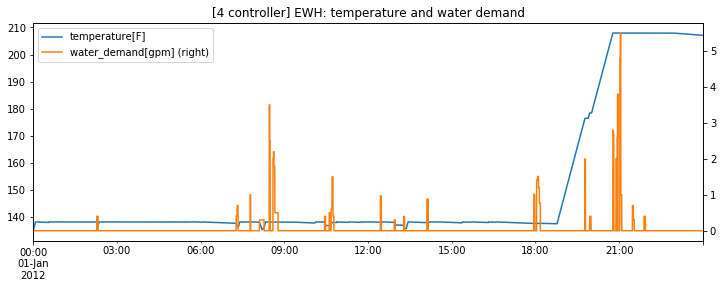

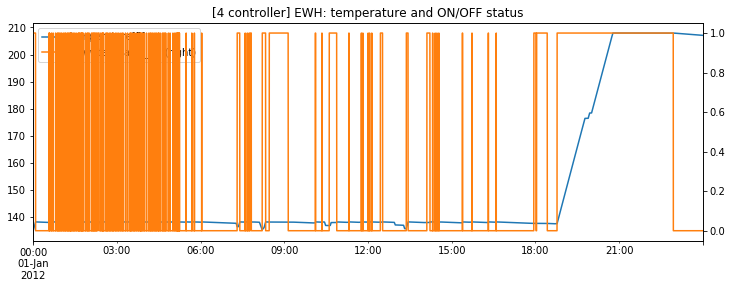

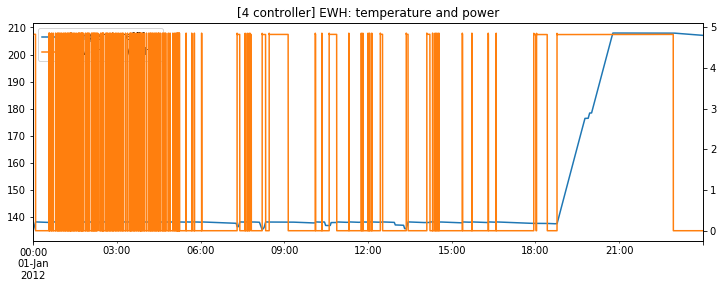

In [63]:
# We save data to wh1_lenient_freq.csv and plot the results
df_wh_4con_2 = pd.read_csv('wh1_4controller_2.csv',sep=',',
                  header=8,index_col=0,parse_dates=True,
                  infer_datetime_format=True,
                  names=['volt[V]', 'freq[Hz]','temperature[F]','power[kW]',
                        'is_waterheater_on','water_demand[gpm]'])

df_wh_4con_2[['temperature[F]','water_demand[gpm]']].\
        plot(figsize=(12,4),secondary_y='water_demand[gpm]',
            title='[4 controller] EWH: temperature and water demand')

df_wh_4con_2[['temperature[F]','is_waterheater_on']].\
        plot(figsize=(12,4),secondary_y='is_waterheater_on',
            title='[4 controller] EWH: temperature and ON/OFF status')

df_wh_4con_2[['temperature[F]','power[kW]']].\
        plot(figsize=(12,4),secondary_y='power[kW]',
            title='[4 controller] EWH: temperature and power')    

Even though we remain the rest parameters the same, we can see the simulation gives abnormal results during 19:00-22:00. This is due to the lock mode controller overrides the thermostat controller and force the load to be ON. Normally we would suggest to put the thermostat controller to the highest priority (set 4 to the last digit of the four-digit integer for controller_priority). If people want to change the priority of the controllers, please make sure to be aware of the possible consequences.